# Budgeting for Education

This is a project from [data driven](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/)

In this project our goal is to predict the probability that a certain label is attached to a budget line item. Each row in the budget has mostly free-form text features, except for two that are noted as float. Any of the fields may or may not be empty.

- The annual budgets for schools are huge, complex and not standardized.
    - Hundreds of hours each year are spent manually labelling

Goal: Build a machine learning algorithm that can automate this process.


# Exploring Raw Data


### Load Data

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from warnings import warn


In [2]:
# Read in data
budget = pd.read_csv('TrainingData.csv', index_col=0)
budget = budget[(budget.FTE >= 0) & (budget.FTE <= 1)]

# First look
pd.concat([budget.head(),budget.tail()])

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.00000,NaN,NaN,KINDERGARTEN,50471.810000,KINDERGARTEN,General Fund,NaN
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.00000,NaN,NaN,TEACHER,62237.130000,Instruction - Regular,General Purpose School,NaN
84272,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,0.60000,NaN,POSITION CONTROL POOLS,TEACHER,38824.790000,Instruction - Regular,General Purpose School,NaN
21870,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,"Operating, Not PreK-12",OTHER PERSONAL SERVICES,...,NaN,CHARTER,0.00000,BASIC (FEFP K-12),NaN,NaN,228.530000,NaN,CONVERSION CHARTER SCHOOLS,NaN
169914,Security & Safety,O&M,Leadership & Management,Non-School,Unspecified,Other,Base Salary/Compensation,Non PreK,PreK-12 Operating,Regular *,...,NaN,SAFETY AND SECURITY DIVISION,1.00000,Security Services,NaN,NaN,66651.255981,NaN,General,SAFETY & SECURITY
72072,School Administration,Leadership,School Reported,School,Unspecified,Vice Principal,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Assistant Principals,...,NaN,NaN,1.00000,NaN,NaN,ASST PRINCIPAL,65258.960000,Principal's Office,General Purpose School,NaN
375092,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Personal Services - Substitute Teachers Certified,...,NaN,NaN,0.00000,NaN,NaN,SUBSTITUTE TEACHER,141.939900,Instruction - Regular,General Purpose School,NaN
220181,Food Services,O&M,Shared Services,School,Unspecified,Other,Base Salary/Compensation,Non PreK,PreK-12 Operating,Salaries Or Wages For Support Personnel,...,Salaries Or Wages For Support Personnel,School,0.09000,Food Services (Child Nutrition Fund Only),Child Nutrition,REG FOOD SERVICE WORKER,2293.931767,Undistributed,National School Breakfast And Lunch Program,REGULAR PAY
102430,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,...,NaN,NaN,0.00431,"TITLE II,D",NaN,PROFESSIONAL-INSTRUCTIONAL,128.824985,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
413949,Parent & Community Relations,NO_LABEL,School Reported,School,NO_LABEL,Other,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.00000,NaN,NaN,PARENT/TITLE I,4902.290000,Misc,Schoolwide Schools,NaN


### Summarize Data

In [3]:
print(budget.shape, '\n')
print(budget.info())
budget.dtypes.value_counts()

(122952, 25) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122952 entries, 134338 to 413949
Data columns (total 25 columns):
Function                  122952 non-null object
Use                       122952 non-null object
Sharing                   122952 non-null object
Reporting                 122952 non-null object
Student_Type              122952 non-null object
Position_Type             122952 non-null object
Object_Type               122952 non-null object
Pre_K                     122952 non-null object
Operating_Status          122952 non-null object
Object_Description        100708 non-null object
Text_2                    35662 non-null object
SubFund_Description       65028 non-null object
Job_Title_Description     102806 non-null object
Text_3                    31029 non-null object
Text_4                    33566 non-null object
Sub_Object_Description    15209 non-null object
Location_Description      52397 non-null object
FTE                       122952 non-null 

object     23
float64     2
dtype: int64

- FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

- Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

In [4]:
budget.describe()

,FTE,Total
count,122952.000000,1.216220e+05
mean,0.406381,2.407274e+04
std,0.447964,4.952192e+04
min,0.000000,-1.431994e+04
25%,0.000000,2.013342e+02
50%,0.100000,4.655923e+03
75%,1.000000,4.253072e+04
max,1.000000,9.252413e+06


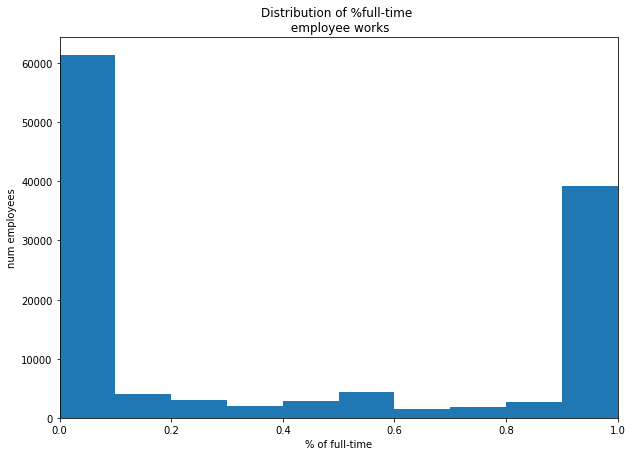

In [5]:
# Create the histogram
plt.figure(figsize=(10,7))
plt.hist(budget.FTE.dropna())

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.xlim(0,1)

# Display the histogram
plt.show()

The high variance in expenditures makes sense (some purchases are cheap some are expensive). Also, it looks like the FTE column is bimodal. That is, there are some part-time and some full-time employees.

### Label and Encode Categorical Data

9 columns of labels in the dataset, 
- Function
- Use
- Sharing
- Reporting
- Student_Type
- Position_Type
- Object_Type
- Pre_K
- Operating_Status

We notice that every label is encoded as an object datatype. Because category datatypes are much more efficient we will convert the labels to category types using the .astype( ) method.

In [6]:
# Create list of labels
labels = ['Function', 'Use', 'Sharing', 'Reporting', 
          'Student_Type', 'Position_Type', 'Object_Type', 
          'Pre_K', 'Operating_Status']

print(budget[labels].dtypes)



# Define lambda function
categorize_label = lambda x: x.astype('category')

# Apply function
budget[labels] = budget[labels].apply(categorize_label, axis=0)
budget[labels].dtypes

Function            object
Use                 object
Sharing             object
Reporting           object
Student_Type        object
Position_Type       object
Object_Type         object
Pre_K               object
Operating_Status    object
dtype: object


Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object

Now we're getting close to something we can work with.  We will now count unique labels.

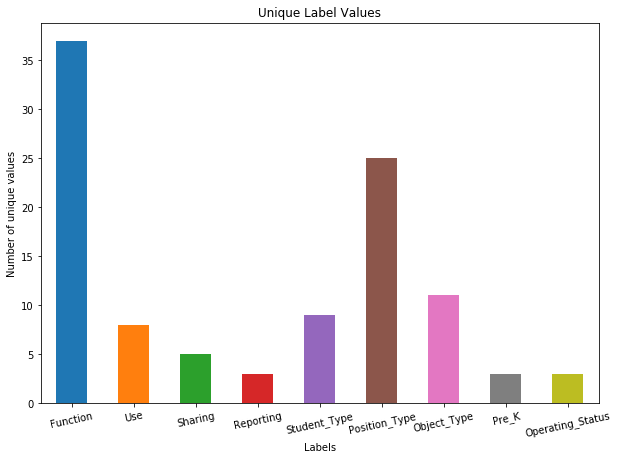

In [7]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = budget[labels].apply(pd.Series.nunique)

# Plot number of unique values for each label
plt.figure(figsize=(10,7))
num_unique_labels.plot(kind='bar')

# Label the axes
plt.title('Unique Label Values')
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.xticks(rotation=12)

# Display the plot
plt.show()

# Build a Model

First we'll split the data into training and test sets. Some labels don't occur often, but we want to make sure that they appear in both the training and test sets. We will create a function that will make sure at least min_count examples of each label appear in each split: multilabel_train_test_split.

In [8]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

### Training a Model

First, we will start with just the numeric columns of our DataFrame.
We will also make numeric NaN values -1000 so that the ML algorithm will respond to them different than 0.

In this project, we will be using the logistic regression and one versus rest classifiers to fit a multi-class logistic regression model.

In training our initial model, we will be throwing away all of the text data in order to get things up and running at this moment.

In [9]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [10]:
# Create the new DataFrame: numeric_data_only
numbers = ['FTE', 'Total']
numeric_data_only = budget[numbers].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(budget[labels])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit classifier to the training data
clf.fit(X_train, y_train)

# Print accuracy
'Accuracy: {}'.format(clf.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

'Accuracy: 0.018137454249694998'

The accuracy was pretty low due to throwing out all of the text data in the budget, but we will now include it. 

### Use NLP to Include Text to Model

We will focus on the `Position_Extra` column, which describes additional information not featured in the `Position_Type` label.

In [11]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create token pattern
tokens_alphanumeric = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values, inplace makes it so we don't have to assign the results
budget.Position_Extra.fillna('', inplace=True)

# Instantiate the CountVectorizer
vec_alphanumeric = CountVectorizer(token_pattern=tokens_alphanumeric)

# Fit the data
vec_alphanumeric.fit(budget.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

There are 364 tokens in Position_Extra if we split on non-alpha numeric
['1st', '2nd', '3rd', '4th', '56', '5th', '9th', 'a', 'ab', 'accountability', 'adaptive', 'addit', 'additional', 'adm', 'admin']


Now we will convert all text data in each row into a single string in order to get a bag-of-words representation.  Then tokenize our rows

In [12]:
# Define combine_text_columns
def combine_text_columns(data_frame, to_drop=numbers + labels):
    """convert all text in each row of the dataframe into a single vector"""
    
    # Drop non-text columns in dataframe
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace NaN with blank
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row
    return text_data.apply(lambda x: ' '.join(x), axis=1)

In [13]:
# Create basic token pattern
tokens_basic = '\\S+(?=\\s+)'

# Create token pattern
tokens_alphanumeric = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic and alphanumeric CountVectorizer
vec_basic = CountVectorizer(token_pattern=tokens_basic)
vec_alphanumeric = CountVectorizer(token_pattern=tokens_alphanumeric)

# Create text vector
text_vector = combine_text_columns(budget)

# Fit and transform
vec_basic.fit_transform(text_vector)
vec_alphanumeric.fit_transform(text_vector)

print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 3100 tokens in the dataset
There are 2117 alpha-numeric tokens in the dataset


We'll keep in mind that alpha-numeric tokenization reduces the number of tokens for our Pipeline object.

# Improve Model with Pipelines
- Repeatable way to go from raw data to a trained model
- Pipeline object takes a sequential list of steps
    - Moves from one step to the other
- Each step is a tuple
    - Name: string
    - Transform: object implementing.fit() and .transform()

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

# Get the columns that are features in the original df
non_labels = [c for c in budget.columns if c not in labels]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(budget[non_labels],
                                                               label_dummies,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns
, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[numbers], validate=False)

# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=tokens_alphanumeric,
                                                   ngram_range=(1, 2)))
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 9 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))



Accuracy on budget dataset:  0.43582757218381457


The logistic regression model is getting better, let's see how other classifiers perform

### Random Forest Classifier

In [15]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Accuracy on budget dataset:  0.9063847092313949


Random forest gave an extremely high improvement.  Let's see what it does when we adjust the parameter within RandomForestClassifier( ).

In [16]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=tokens_alphanumeric,
                                                   ngram_range=(1, 2)))
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



Accuracy on budget dataset:  0.9134200894672632


We improved to 91% accuracy with the parameter adjustment.